# 2021-22赛季NBA数据分析及预测

Eric.Windsor
2022/11/01

## 简介

* 项目目标:
1. 通过网络爬虫的方式获取2021-2022赛季NBA的比赛数据,并以XLS的格式保存

2. 进行数据清洗后将其转化为一个可以进行数据分析的数据集并可视化分析具体的问题

3. 根据ELO算法训练模型,并以此预测22-23赛季的比赛结果

* 调用包:
requests(URL请求);etree(解析网页);pandas(构建dataframe);sklearn(建模)

* 数据源:
BBR 个人认为可能是最好的篮球数据网站:
https://www.basketball-reference.com/leagues/NBA_2022.html


## 数据爬取:

需要获得三张表的数据进行数据分析:

1. 赛季总览数据(见下图示例):team/opponent分别代表A球队的平均表现以及A球队对手的平均表现
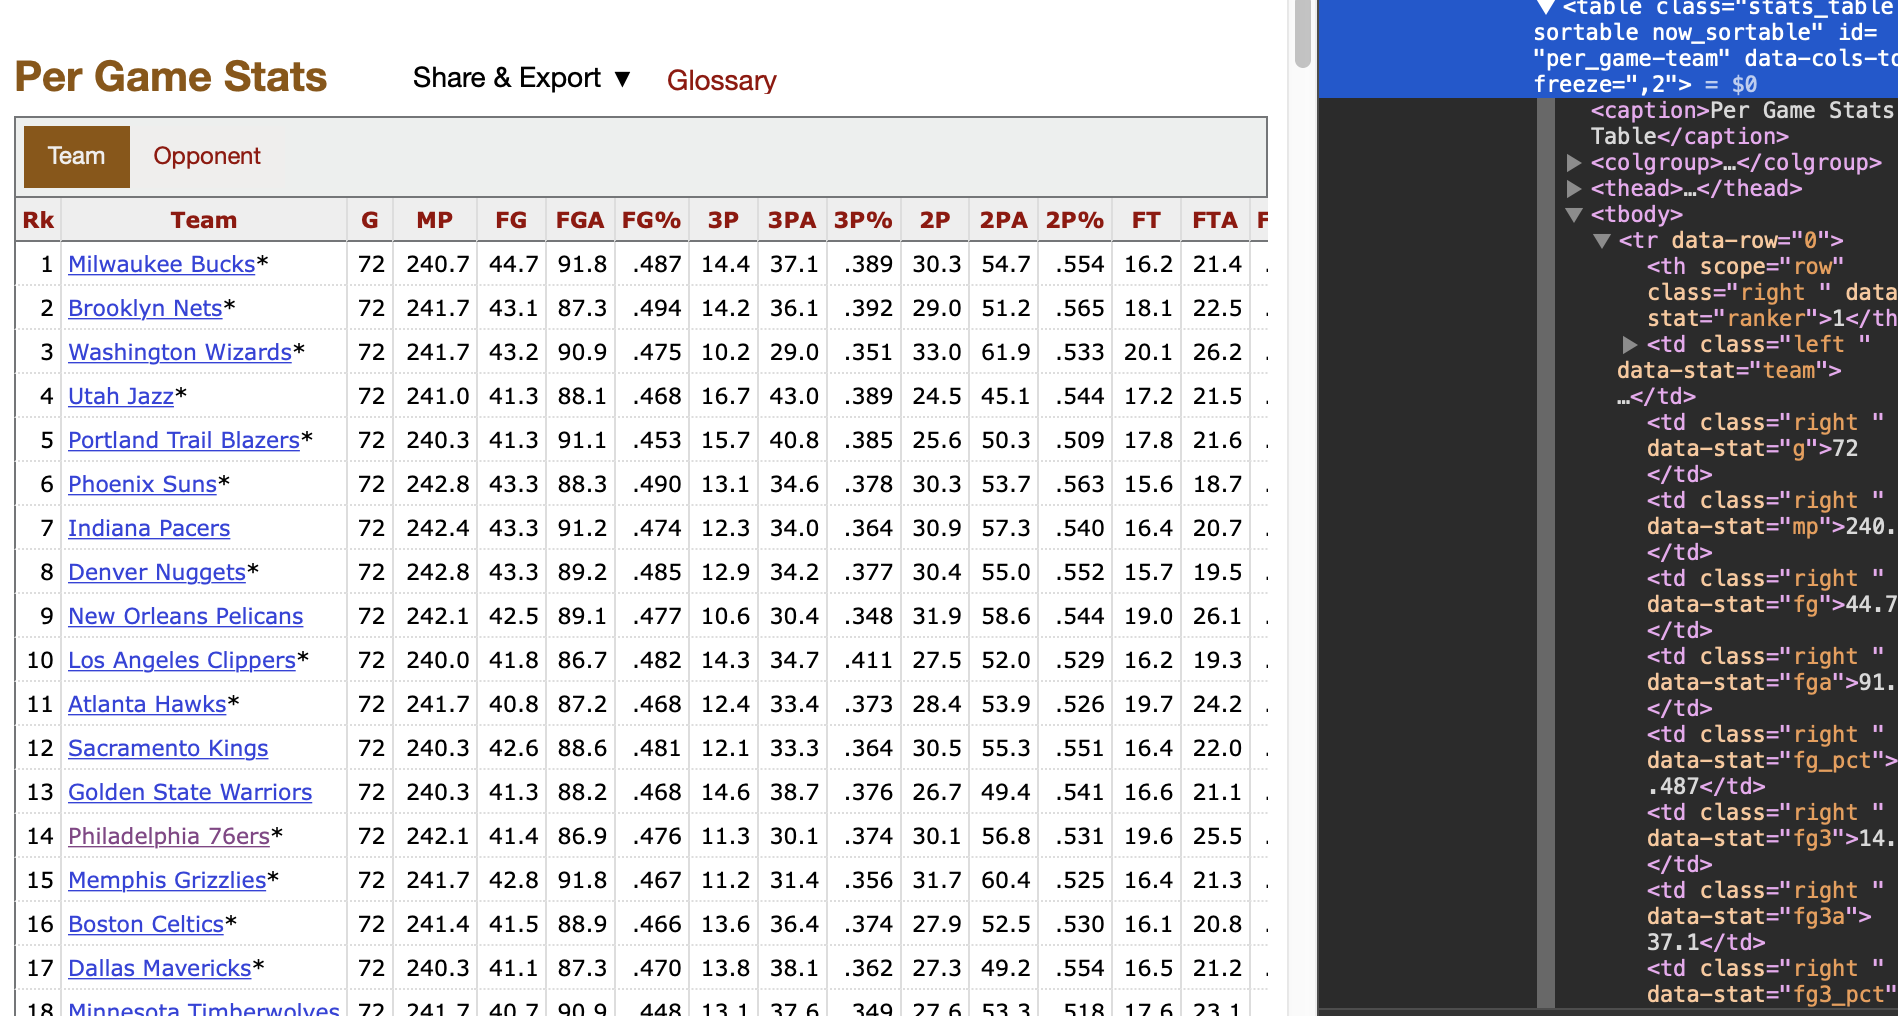
2. 赛季进阶数据:更细致的反应出每队的平均表现
3. 赛季月度数据:21-22赛季的赛程及结果

In [135]:
import requests
from lxml import etree

# 2021-22 基础数据URL
base_url = 'https://www.basketball-reference.com/leagues/NBA_2022.html'
# 2021-22 {月度}数据URL
months = ["october", "november", "december", "january", "february", "march", "april", "may", "june"]
schedule_url = "https://www.basketball-reference.com/leagues/NBA_2022_games-{}.html"
# 请求头
headers = {'User-Agent': 'python-requests/2.27.1', 'Accept-Encoding': 'gzip, deflate, br', 'Accept': '*/*', 'Connection': 'keep-alive'}
def get_etrees(url,headers):
    response = requests.get(url=url,headers=headers,timeout=30)
    response.encoding = 'utf-8'
# 验证服务器的返回结果
#     status = response.status_code
# 这个网站对请求要求比较严格,使用浏览器的UA会被识破,经过多次尝试,上文的headers直接使用了session.header的返回结果
#     session = requests.Session()
    html_text = response.text
    etree_instance = etree.HTML(html_text)
    return etree_instance  

In [149]:
# 根据以上URL实例化etree对象用以解析网页
base_tree = get_etrees(base_url,headers)
month_tree_dict = {}
for month in months:
    month_tree_dict[month] = get_etrees(schedule_url.format(month),headers)


## 解析数据:

-- 通过网页分析,可以发现需要的数据都在`<table>`标签下
-- 将每个table结构拆分来看,都是表头+表格体的形式,可以抽象两个方法用于提取表头及表格体

In [268]:
# 找到各个表格的table部分,分别为队伍数据统计,该队对手数据统计以及队伍进阶数据统计
base_tree_team_table = base_tree.xpath('//table[@id="per_game-team"]')[0]
base_tree_opponent_table = base_tree.xpath('//table[@id="per_game-opponent"]')[0]
advaced_tree_team_table = base_tree.xpath('//table[@id="advanced-team"]')[0]

# 获取表头
def get_table_head(table):
    head_list = []
    for tr in table.xpath('./thead/tr[not(@class)]'):
        table_head=tr.xpath('./th/text()')
        head_list.append(table_head)
        
    return head_list[0]

# 获取表格体
def get_table_body(table):
    data_list=[]
    trs = table.xpath('./tbody/tr')
    for tr in trs:
        rk = tr.xpath('./th/text()')
        datas = tr.xpath('./td[@data-stat!="DUMMY"]/text()')
        datas[0] = tr.xpath('./td/a/text()')[0]
        datas.insert(0, rk[0])
        data_list.append(datas)
        
    return data_list

# 组成表格
def get_table(table):
    heads = get_table_head(table)
    datas = get_table_body(table)
    return heads,datas

# 各队月份数据表
# Notes:这张月份表无法复用之前构建表格的方法因为表格体构造不同,所以单独写了一个方法
def get_month_table():
    data_list = []
    for i in month_tree_dict.values():
        month_table = i.xpath('//table[@id="schedule"]')[0]
        header=get_table_head(month_table)
        trs = month_table.xpath('./tbody/tr')
        for tr in trs:
            dt = tr.xpath('./th//text()')
            datas = tr.xpath('./td/text()')
# 把需要特殊定位的元素按表头顺序插入到数据中
            datas.insert(1,tr.xpath('./td/a/text()')[0])
            datas.insert(3,tr.xpath('./td/a/text()')[1])
            datas.insert(5,tr.xpath('./td/a/text()')[2])
            datas.insert(0,dt[0])
            data_list.append(datas)
    return header,data_list

# 存储成csv文件
import csv
def save_csv(title, heads, rows):
    f = open(title + '.csv', mode='w', encoding='utf-8', newline='')
    csv_writer = csv.writer(f)
    csv_writer.writerow(heads)
    for row in rows:
        csv_writer.writerow(row)

In [269]:
# 保存表头,表格体
team_head,team_data = get_table(base_tree_team_table)
opponent_head,opponent_data = get_table(base_tree_opponent_table)
advanced_head,advanced_data = get_table(advaced_tree_team_table)
month_head,month_data = get_month_table()
# 保存文件
save_csv('team-stat',team_head,team_data )
save_csv('opponent-stat',opponent_head,opponent_data)
save_csv('advanced-stat',advanced_head,advanced_data)
save_csv('month-stat',month_head,month_data )


## 数据可视化:

可视化部分希望能够解答两个问题:

1. 我们经常在体育比赛中听到主场优势这个词,它涵盖很多因素比如比赛的地理环境,观众的支持程度,裁判的判罚尺度等等,NBA主场优势这个说法正确吗?

2. 21赛季的总冠军球队,勇士队每月的比赛中,主客场获胜场次变化趋势是怎样的?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

month_df = pd.read_csv('./month-stat.csv',index_col='Date',parse_dates=True)

In [2]:
month_df.head()

,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,,.1,Attend.,Arena,Notes
Date,,,,,,,,,,
2021-10-19,7:30p,Brooklyn Nets,104,Milwaukee Bucks,127,Box Score,"17,341",Fiserv Forum,NaN,NaN
2021-10-19,10:00p,Golden State Warriors,121,Los Angeles Lakers,114,Box Score,"18,997",Crypto.com Arena,NaN,NaN
2021-10-20,7:00p,Indiana Pacers,122,Charlotte Hornets,123,Box Score,"15,521",Spectrum Center,NaN,NaN
2021-10-20,7:00p,Chicago Bulls,94,Detroit Pistons,88,Box Score,"20,088",Little Caesars Arena,NaN,NaN
2021-10-20,7:30p,Boston Celtics,134,New York Knicks,138,Box Score,2OT,"19,812",Madison Square Garden (IV),NaN


上面的表格中存在空列名,重复列名以及一些不需要的列,所以对初始数据进行'瘦身',只保留[时间,客队,客队得分,主队,主队得分]列

In [3]:
month_df_slim = month_df.drop(list(month_df)[5:],axis=1).drop(columns='Start (ET)').rename(
    columns={'PTS':'V/N_PTS','PTS.1':'H/N_PTS'}
)

In [4]:
# 根据主客场比分新增胜者(Winner)列,客场胜则为V,主场胜则为H
def getwinner(df):
    if df[1]>df[3]:
        return 'V'
    else:
        return 'H'
    
month_df_slim['Winner'] = month_df_slim.apply(lambda df:getwinner(df),axis=1)

In [5]:
month_df_slim.head()

,Visitor/Neutral,V/N_PTS,Home/Neutral,H/N_PTS,Winner
Date,,,,,
2021-10-19,Brooklyn Nets,104,Milwaukee Bucks,127,H
2021-10-19,Golden State Warriors,121,Los Angeles Lakers,114,V
2021-10-20,Indiana Pacers,122,Charlotte Hornets,123,H
2021-10-20,Chicago Bulls,94,Detroit Pistons,88,V
2021-10-20,Boston Celtics,134,New York Knicks,138,H


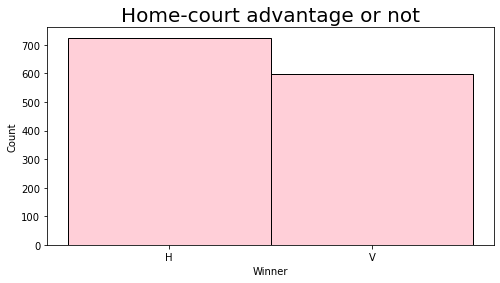

In [6]:
# 根据主/客场的胜场次数总和绘制图表
plt.figure(figsize=(8,4))
plt.title('Home-court advantage or not',size=20)
hp = sns.histplot(data=month_df_slim['Winner'],color='pink')
plt.show()


从图中可以发现,主场优势确实存在;21-22赛季主场获胜的场次竟然比客场多出仅100场!

这简直是一个惊人的数字,所以常规赛排名对每一个希望在季后赛中取得好成绩的球队至关重要
(季后赛的赛制是7局4胜,优先在排名高的球队主场进行比赛)

In [7]:
# 分别取出勇士队主/客场获胜的数据
V_wins=month_df_slim.loc[(month_df_slim['Visitor/Neutral']=='Golden State Warriors')&(month_df_slim['Winner']=='V'),:]
H_wins=month_df_slim.loc[(month_df_slim['Visitor/Neutral']=='Golden State Warriors')&(month_df_slim['Winner']=='H'),:]

#按月分组
def to_dataframe(df):
    df = df.groupby(df.index.month).size().to_frame()
    df = df.rename(columns={0:'Wins_count'})   
    return df

V_wins_df=to_dataframe(V_wins)
H_wins_df=to_dataframe(H_wins)

In [8]:
# 构建新dataframe方便后续绘图
final_df = V_wins_df.merge(H_wins_df,left_index=True,right_index=True,how='outer',suffixes=('_V','_H')).fillna(0)

# 勇士队10月的比赛主场没有赢过,所以存在缺失值,merge的时候就会有浮点数存在,没有找到更好的方法在连表时进行处理,只能二次修改type
final_df['Wins_count_H']=final_df['Wins_count_H'].astype(int)


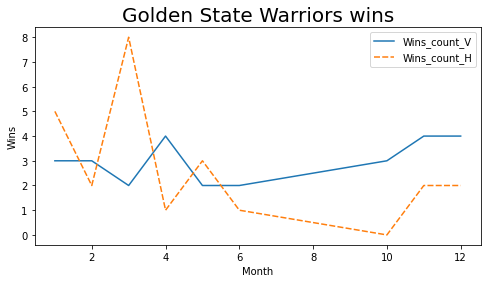

In [9]:
# 绘图
plt.figure(figsize=(8,4))
plt.title('Golden State Warriors wins',size=20)
plt.xlabel('Month')
plt.ylabel('Wins')
hp = sns.lineplot(data=final_df)

plt.show()


总体而言,勇士队的客场表现更加平稳而主场反而起伏不定

三月的时候,勇士队主场获胜次数达到最高峰值,客场获胜次数达到最低峰值,他们究竟了经历了什么..

因为NBA赛程的关系并不能确保球队每个月的比赛总数是一致的,更何况球队对手强弱,球队伤病情况以及其他一些会对比赛结果产生影响的因素
所以不能武断的得出勇士队更擅长客场作战的结论

## 基于ELO算法进行预测

ELO算法是一种对于博弈双方评估相对等级的算法,应用范围很广泛,首次应用于国际象棋比赛中;
如今,围棋,游戏匹配机制等多重领域的评估系统中都使用其参与

通俗来说,ELO就是一种积分,用数学公式表示为:

Ra: A选手当前分数
Rb: B选手当前分数

Ea: 预期A选手的胜负值
Ea = 1/(1+10^[(Rb-Ra)/400])

Eb: 预期B选手的胜负值
Eb = 1/(1+10^[(Ra-Rb)/400])

E值也是预估的双方胜率，所以 Ea + Eb = 1

Sa: 实际胜负值，胜 = 1， 平 = 0.5， 负 = 0,由于在NBA比赛中没有平局的概念,所以本项目的S = (0,1)

K： 每场比赛能得到的最大分数即极限值,一般而言R越大的选手K越小

R'a: A选手一场比赛之后的积分
R'a = Ra + K(Sa-Ea)

R'b: B选手一场比赛之后的积分
R'b = Rb + K(Sb-Eb)

接下来的ELO计算参考了Nate和Reuben的这篇文章:https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings

向Real MVP表示感谢!

### 关键词 :
* 主场优势:从上文可以发现主场会对比赛的胜负产生一定影响,所以对于每一个主场球队会额外获得100的ELO积分
* 初始积分:R = 1300
* K = 20*MOV系数
* 净胜分(MOV):

在文章里,作者提出净胜分(margin of victory)对K值的影响, 所以增加了K值系数来重新计算K值

公式为:K = 20\*(MOV+3)\** 0.8/(7.5+0.006\*(elo_difference)),其中:elo_difference = winning_elo−losing_elo.

举例而言,在勇士(主场)与火箭的比赛中,假设勇士与火箭的分差为4分且ELO差值(勇士的ELO-火箭ELO)=118,那么勇士队的K值系数为:

勇士胜:pow(7,0.8)/(7.5+0.006\*218)=0.54
火箭胜:pow(7,0.8)/(7.5-0.006\*218)=0.77


In [10]:
# 计算主客场E值
def getE(R_home,R_visitor):
    E_home = 1./(1+10**((R_visitor-R_home)/(400.)))
    E_visitor = 1-E_home
    return E_home,E_visitor

# 计算K值
def getK(MOV,elo_diff):
    K = 20.
    if MOV > 0:
        K *= (MOV + 3) ** (0.8) / (7.5 + 0.006 * (elo_diff))
    else:
        K *= ( -MOV + 3) ** (0.8) / (7.5 + 0.006 * (-elo_diff))
    return K

# 获得球队的ELO积分:
team_ELO = {}
R_base = 1300.
def get_ELO(team):
    try:
        return team_ELO[team]
    except:
        team_ELO[team] = R_base
        return team_ELO[team]
    
# 更新ELO积分(基于上文的month_df_slim构建函数):
def update_ELO(score_home,score_visitor,team_home,team_visitor,S):
    #主场优势
    home_ad = 100.
    #计算K
    MOV = score_home-score_visitor
    R_home = get_ELO(team_home)+home_ad
    R_visitor = get_ELO(team_visitor)
    elo_diff = R_home-R_visitor
    K = getK(MOV,elo_diff)
    #计算E
    E_home,E_visitor = getE(R_home,R_visitor)
    # bool值为1,0
    S_home = int(S=='H')
    S_vistior = int(S=='V')
    # 新的ELO积分,四舍五入
    new_r_home = round(R_home+K*(S_home-E_home))
    new_r_vistor = round(R_visitor+K*(S_vistior-E_visitor))
    return new_r_home,new_r_vistor

接下来训练模型并得到预测的比赛结果,训练数据集选择使用上文的team-stat,opponent_stat,advanced-stat联表;这三张表中的字段反应了每支球队的赛季平均表现;

模型选择了逻辑回归模型,因为NBA比赛结果非输即赢,这个模型很擅长处理这种二项分类结果;X使用联表后的字段以及计算的球队ELO值,y为比赛结果

In [11]:
# 联表
team_df = pd.read_csv('./team-stat.csv',index_col='Team').drop(['Rk','G','MP'], axis=1)
opponent_df = pd.read_csv('./opponent-stat.csv',index_col='Team').drop(['Rk','G','MP'], axis=1)
advanced_df = pd.read_csv('./advanced-stat.csv',index_col='Team').drop(['Rk','Arena','Attend.','Attend./G'], axis=1).dropna(axis=1)
new_team_df = team_df.merge(opponent_df,left_index=True,right_index=True,how='left',suffixes = ('_t','_o'))
new_df = new_team_df.merge(advanced_df,left_index=True,right_index=True,how='left',suffixes=('','_a'))

In [12]:
# 展示全部的行,列
pd.options.display.max_columns = None
pd.options.display.max_rows = None
new_df

,FG_t,FGA_t,FG%_t,3P_t,3PA_t,3P%_t,2P_t,2PA_t,2P%_t,FT_t,FTA_t,FT%_t,ORB_t,DRB_t,TRB_t,AST_t,STL_t,BLK_t,TOV_t,PF_t,PTS_t,FG_o,FGA_o,FG%_o,3P_o,3PA_o,3P%_o,2P_o,2PA_o,2P%_o,FT_o,FTA_o,FT%_o,ORB_o,DRB_o,TRB_o,AST_o,STL_o,BLK_o,TOV_o,PF_o,PTS_o,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
Team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Minnesota Timberwolves,3411,7458,0.457,1211,3386,0.358,2200,4072,0.540,1474,1894,0.778,921,2700,3621,2106,721,460,1175,1786,9507,3298,7163,0.460,1071,3062,0.350,2227,4101,0.543,1624,2081,0.780,904,2858,3762,2149,593,397,1339,1715,9291,24.2,46,36,48,34,2.63,-0.10,2.53,114.3,111.7,2.6,100.9,0.254,0.454,0.573,0.539,12.4,24.4,0.198,0.535,14.2,74.9,0.227
Memphis Grizzlies,3571,7739,0.461,945,2679,0.353,2626,5060,0.519,1393,1898,0.734,1159,2873,4032,2131,800,533,1082,1620,9480,3305,7269,0.455,987,2828,0.349,2318,4441,0.522,1417,1837,0.771,821,2706,3527,2047,588,496,1235,1625,9014,24.0,56,26,55,27,5.68,-0.32,5.37,114.6,109.0,5.6,100.3,0.245,0.346,0.553,0.522,11.2,30.0,0.180,0.523,13.3,77.8,0.195
Milwaukee Bucks,3429,7331,0.468,1153,3151,0.366,2276,4180,0.544,1459,1881,0.776,840,2990,3830,1960,623,326,1100,1494,9470,3391,7431,0.456,1186,3328,0.356,2205,4103,0.537,1227,1634,0.751,812,2805,3617,2122,606,357,1070,1612,9195,28.5,51,31,49,33,3.35,-0.14,3.22,115.1,111.8,3.3,99.9,0.257,0.430,0.580,0.546,11.9,23.0,0.199,0.536,11.6,78.6,0.165
Charlotte Hornets,3508,7497,0.468,1143,3130,0.365,2365,4367,0.542,1298,1753,0.740,888,2767,3655,2302,707,402,1087,1629,9457,3444,7388,0.466,1148,3170,0.362,2296,4218,0.544,1385,1815,0.763,931,2920,3851,2169,617,377,1229,1609,9421,25.5,43,39,42,40,0.44,0.09,0.53,114.1,113.7,0.4,100.0,0.234,0.418,0.572,0.544,11.6,23.3,0.173,0.544,13.1,74.8,0.187
Phoenix Suns,3581,7389,0.485,951,2616,0.364,2630,4773,0.551,1303,1635,0.797,801,2913,3714,2244,702,359,1060,1633,9416,3216,7243,0.444,953,2805,0.340,2263,4438,0.510,1416,1861,0.761,863,2783,3646,1875,614,327,1206,1553,8801,27.5,64,18,59,23,7.50,-0.56,6.94,114.8,107.3,7.5,99.8,0.221,0.354,0.581,0.549,11.6,22.3,0.176,0.510,13.0,77.1,0.195
Atlanta Hawks,3401,7241,0.470,1056,2821,0.374,2345,4420,0.531,1485,1829,0.812,823,2783,3606,2017,587,348,972,1534,9343,3435,7294,0.471,1051,2888,0.364,2384,4406,0.541,1294,1634,0.792,838,2758,3596,2085,576,367,1046,1668,9215,26.1,43,39,45,37,1.56,-0.01,1.55,116.5,114.9,1.6,97.7,0.253,0.390,0.581,0.543,10.8,23.0,0.205,0.543,11.5,76.9,0.177
Utah Jazz,3327,7067,0.471,1192,3308,0.360,2135,3759,0.568,1470,1916,0.767,884,2916,3800,1836,588,402,1149,1547,9316,3314,7318,0.453,994,2837,0.350,2320,4481,0.518,1199,1581,0.758,809,2599,3408,1917,636,352,982,1664,8821,29.3,49,33,56,26,6.04,-0.37,5.67,116.7,110.5,6.2,97.1,0.271,0.468,0.589,0.555,12.7,25.4,0.208,0.521,10.9,78.3,0.164
San Antonio Spurs,3546,7601,0.467,925,2626,0.352,2621,4975,0.527,1262,1673,0.754,901,2815,3716,2289,626,403,1042,1483,9279,3482,7475,0.466,992,2756,0.360,2490,4719,0.528,1313,1711,0.767,933,2902,3835,1970,601,403,1131,1553,9269,24.5,34,48,41,41,0.12,-0.10,0.02,112.4,112.3,0.1,100.0,0.220,0.345,0.556,0.527,11.1,23.7,0.166,0.532,12.1,75.1,0.176
Brooklyn Nets,3442,7251,0.475,940,2602,0.361,2502,4649,0.538,1434,1781,0.805,844,2796,3640,2071,582,448,1153,1670,9258,3340,7395,0.452,1026,2974,0.345,2314,4421,0.523,1488,1888,0.788,926,2690,3616,1954,650,403,1088,1616,9194,29.1,44,38,43,39,0.78,0.04,0.82,113.6,112.8,0.8,99.0,0.246,0.359,0.576,0.540,12.5,23.9,0.198,0.521,11.7,75.1,0.201


In [13]:
month_df_slim.reset_index(drop=True, inplace=True) 
X=[]
y=[]

# 逐行遍历dataframe
for index,row in month_df_slim.iterrows():
    team_home_X = []
    team_visitor_X = []
    team_home = row['Home/Neutral']
    team_visitor = row['Visitor/Neutral']   
    score_home = row['H/N_PTS']
    score_visitor = row['V/N_PTS']
    winner = row['Winner']
    new_r_home,new_r_vistor = update_ELO(score_home,score_visitor,team_home,team_visitor,winner)
    
# 根据每场比赛结果更新ELO积分
    team_ELO[team_home] = new_r_home
    team_ELO[team_visitor] = new_r_vistor

# 将每场比赛的ELO积分插进df
    month_df_slim.at[index,['R_home']] = new_r_home
    month_df_slim.at[index,['R_visitor']] = new_r_vistor
    
# 把主/客场的ELO积分添加至X
    team_home_X.append(new_r_home)
    team_visitor_X.append(new_r_vistor)
    
# 把每支队伍的其他特征添加至X
    for key,value in new_df.loc[team_home].iteritems():
        team_home_X.append(value)
    for key,value in new_df.loc[team_visitor].iteritems():
        team_visitor_X.append(value)
        
# 把每场比赛的结果添加至y
    y.append(int(row['Winner']=='H'))        
# 把主/客场的X合并为总X
    X.append(team_home_X+team_visitor_X)
           

In [14]:
month_df_slim

,Visitor/Neutral,V/N_PTS,Home/Neutral,H/N_PTS,Winner,R_home,R_visitor
0,Brooklyn Nets,104,Milwaukee Bucks,127,H,1412.0,1288.0
1,Golden State Warriors,121,Los Angeles Lakers,114,V,1388.0,1312.0
2,Indiana Pacers,122,Charlotte Hornets,123,H,1403.0,1297.0
3,Chicago Bulls,94,Detroit Pistons,88,V,1389.0,1311.0
4,Boston Celtics,134,New York Knicks,138,H,1404.0,1296.0
5,Washington Wizards,98,Toronto Raptors,83,V,1381.0,1319.0
6,Cleveland Cavaliers,121,Memphis Grizzlies,132,H,1407.0,1293.0
7,Houston Rockets,106,Minnesota Timberwolves,124,H,1410.0,1290.0
8,Philadelphia 76ers,117,New Orleans Pelicans,97,V,1377.0,1323.0
9,Orlando Magic,97,San Antonio Spurs,123,H,1413.0,1287.0


In [15]:
team_ELO

{'Milwaukee Bucks': 6011,
 'Brooklyn Nets': 5841,
 'Los Angeles Lakers': 5107,
 'Golden State Warriors': 6748,
 'Charlotte Hornets': 5544,
 'Indiana Pacers': 5143,
 'Detroit Pistons': 5324,
 'Chicago Bulls': 5542,
 'New York Knicks': 5447,
 'Boston Celtics': 6824,
 'Toronto Raptors': 5853,
 'Washington Wizards': 5322,
 'Memphis Grizzlies': 6074,
 'Cleveland Cavaliers': 5531,
 'Minnesota Timberwolves': 5856,
 'Houston Rockets': 5285,
 'New Orleans Pelicans': 5814,
 'Philadelphia 76ers': 6203,
 'San Antonio Spurs': 5377,
 'Orlando Magic': 5401,
 'Utah Jazz': 5714,
 'Oklahoma City Thunder': 5219,
 'Portland Trail Blazers': 5002,
 'Sacramento Kings': 5089,
 'Phoenix Suns': 6132,
 'Denver Nuggets': 5777,
 'Atlanta Hawks': 5774,
 'Dallas Mavericks': 6314,
 'Miami Heat': 6613,
 'Los Angeles Clippers': 5419}

赛季最终的结果中有一个很有趣的事实:勇士队的ELO积分<凯尔特队的ELO积分,但最终捧起奥布莱恩杯的却是勇士队

数据可能会说谎,但篮球不会

In [16]:
from sklearn import linear_model

# 训练模型
model = linear_model.LogisticRegression()
model.fit(X, y)

# 验证准确率
print ('Model Accuracy (Logistic Regression) = {:.3f}'.format(model.score(X,y)))

Model Accuracy (Logistic Regression) = 0.683


/Users/ericwindsor/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


写到这里的时候突然发现网站贴心的提供了CSV格式(入口见下图),所以前面为什么要写爬虫..UA那里还折腾了不少时间..
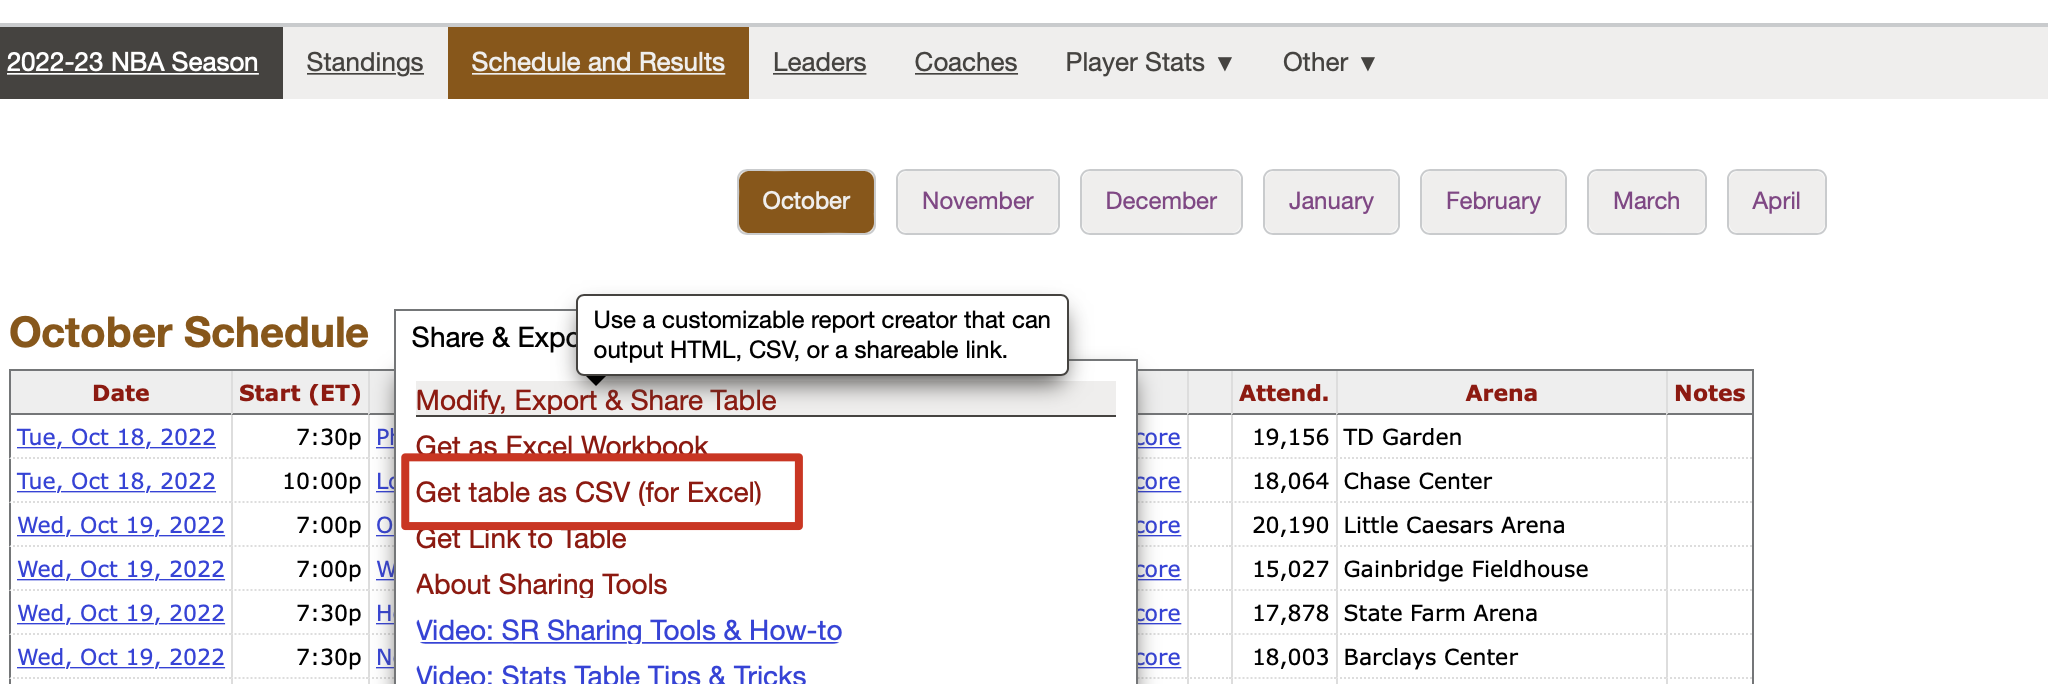

In [17]:
# 使用22-23赛季的赛程作为预测数据集
schedule_stat = pd.read_csv('./schedule2023.csv',usecols=['Visitor/Neutral','Home/Neutral'])
test_X = []
# 和前文一样的逻辑
for index,row in schedule_stat.iterrows():
    test_team_home_X=[]
    test_team_visitor_X=[]
    test_team_home = row['Home/Neutral']
    test_team_visitor = row['Visitor/Neutral']
    test_ELO_home = get_ELO(test_team_home)
    test_ELO_visitor = get_ELO(test_team_visitor)
    test_team_home_X.append(test_ELO_home)
    test_team_visitor_X.append(test_ELO_visitor)
    for key,value in new_df.loc[test_team_home].iteritems():
        test_team_home_X.append(value)
    for key,value in new_df.loc[test_team_visitor].iteritems():
        test_team_visitor_X.append(value)
    test_X.append(test_team_home_X+test_team_visitor_X)
winner = model.predict(test_X)

In [19]:
schedule_stat['Winner'] = winner
# 主场胜:'H',客场胜'V'
schedule_stat['Winner']=schedule_stat['Winner'].apply(lambda cl: 'H' if cl==1 else 'V')    

In [20]:
schedule_stat

,Visitor/Neutral,Home/Neutral,Winner
0,Philadelphia 76ers,Boston Celtics,H
1,Los Angeles Lakers,Golden State Warriors,H
2,Orlando Magic,Detroit Pistons,V
3,Washington Wizards,Indiana Pacers,V
4,Houston Rockets,Atlanta Hawks,H
5,New Orleans Pelicans,Brooklyn Nets,V
6,New York Knicks,Memphis Grizzlies,H
7,Chicago Bulls,Miami Heat,H
8,Cleveland Cavaliers,Toronto Raptors,H
9,Oklahoma City Thunder,Minnesota Timberwolves,H


## 结论

基于ELO算法训练的模型准确率达到了66.1%,但在23赛季的预测中,因为无法获得比赛的分数,所以只能使用22赛季每队最终的ELO积分作为特征值,所以预测结果并不是很有说服力;
在模型的特征值选择中,使用球队赛季平均表现实际上是一个非常取巧的方式,将其作为每场比赛的特征事实上也不是很合适;
如果需要获得更准确的结果,后续还有很多工作要做